Using cpu device
Done!0


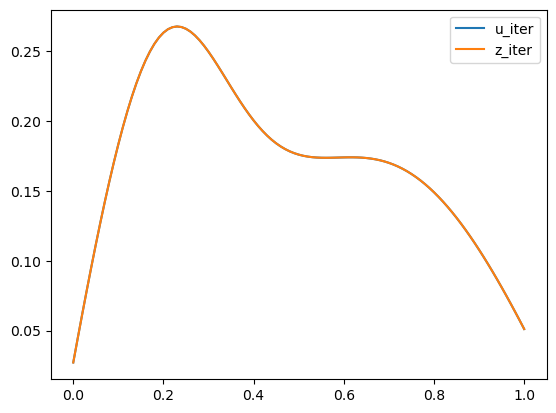

Done!1


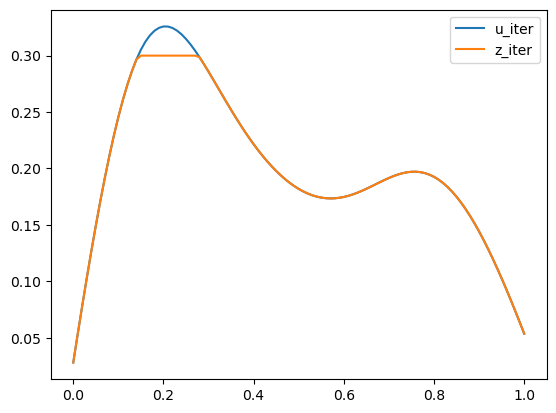

Done!2


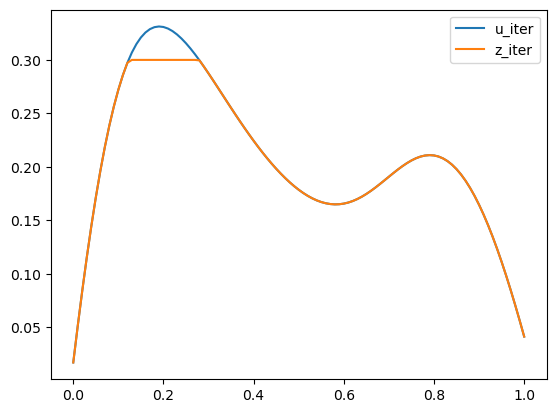

Done!3


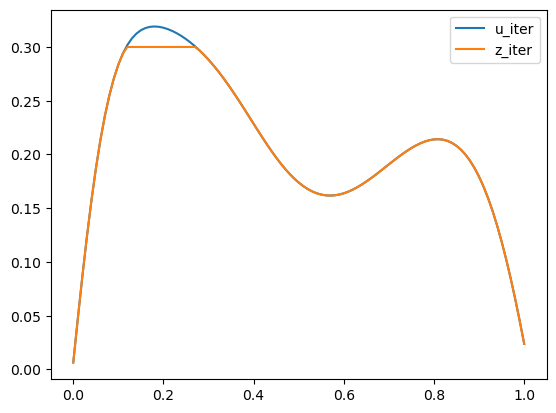

Done!4


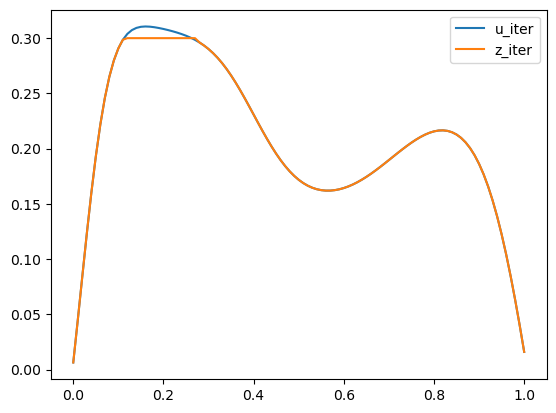

Done!5


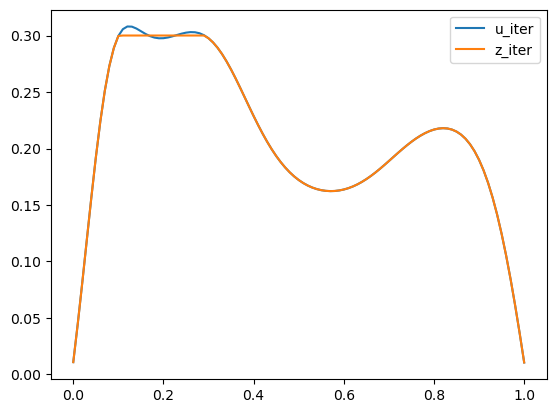

Done!6


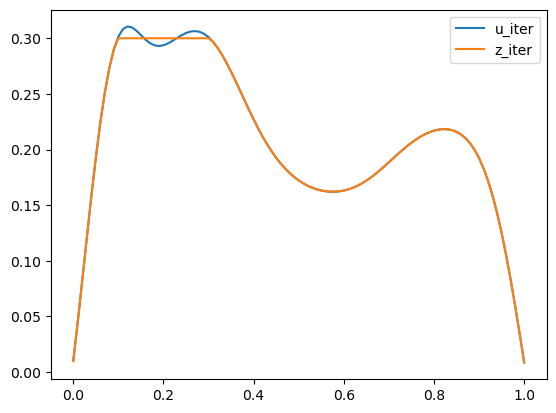

Done!7


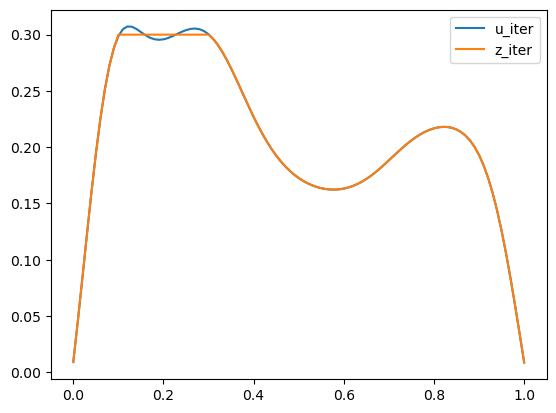

Done!8


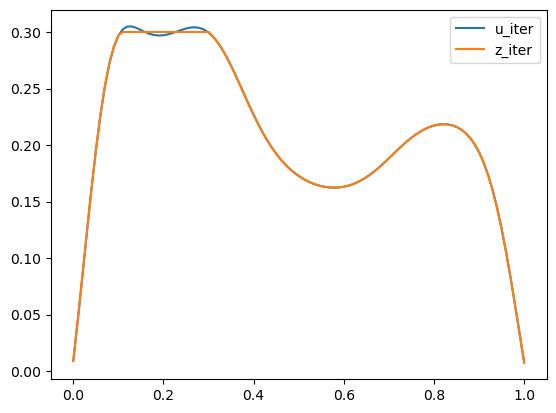

Done!9


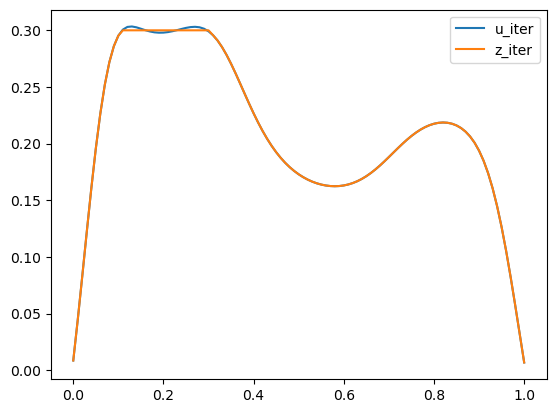

Done!10


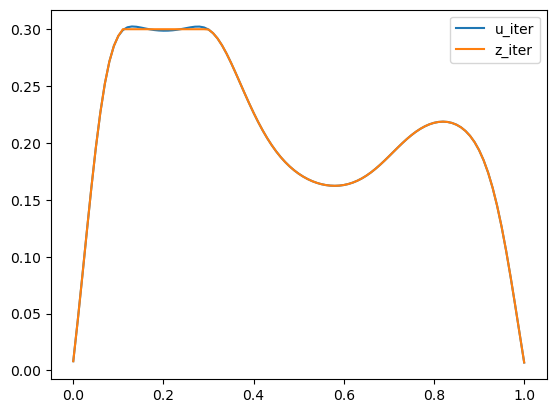

Done!11


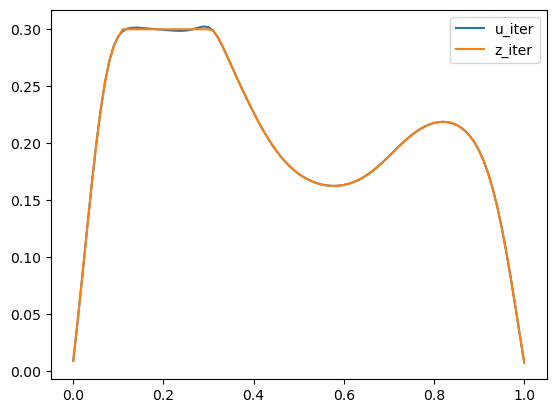

Done!12


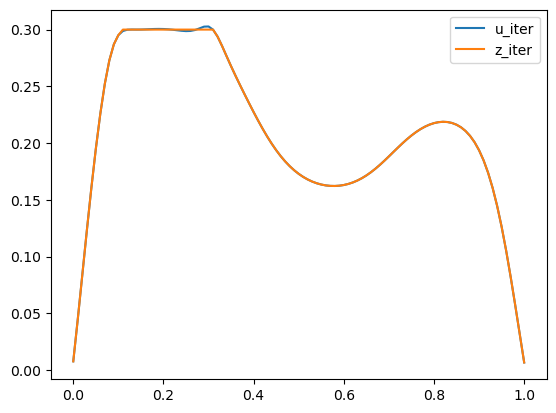

Done!13


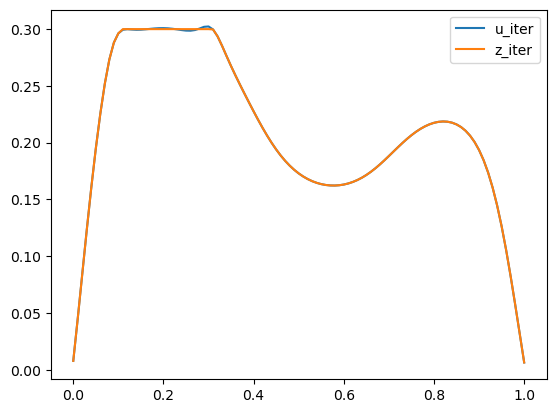

Done!14


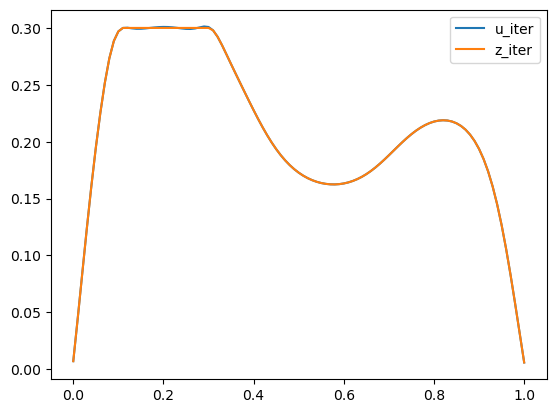

Done!15


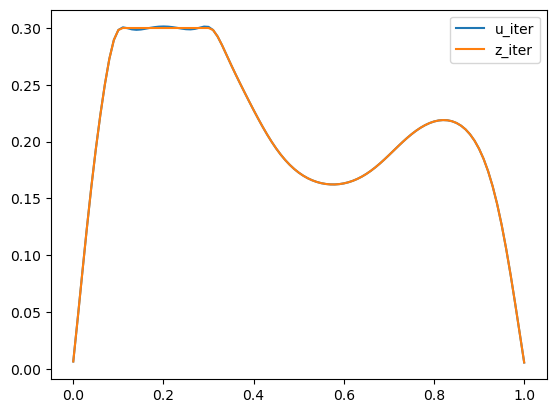

Done!16


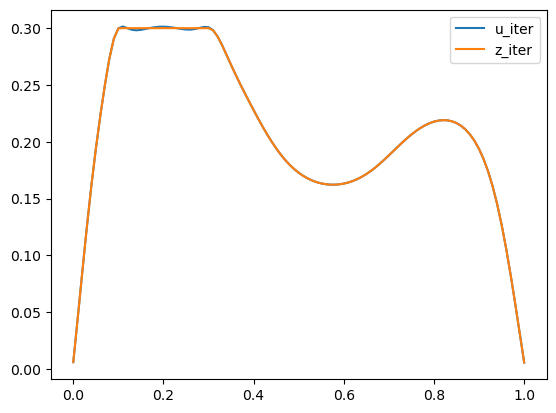

Done!17


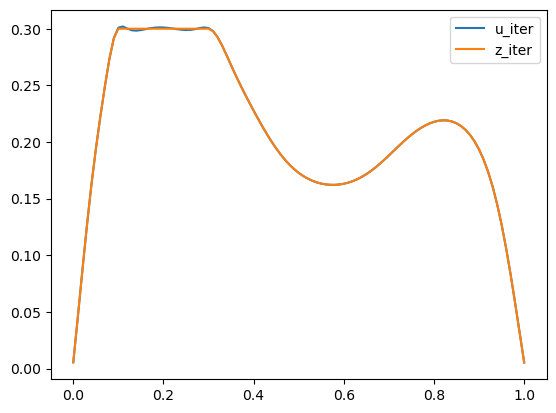

Done!18


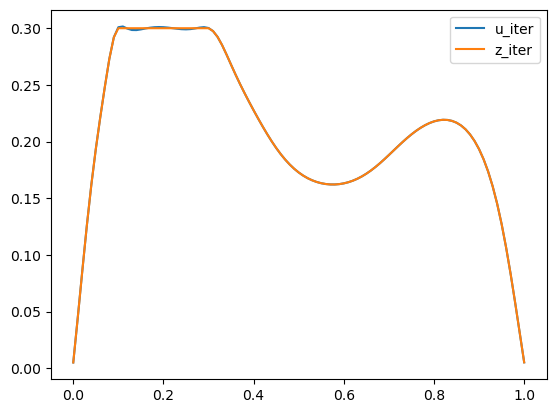

Done!19


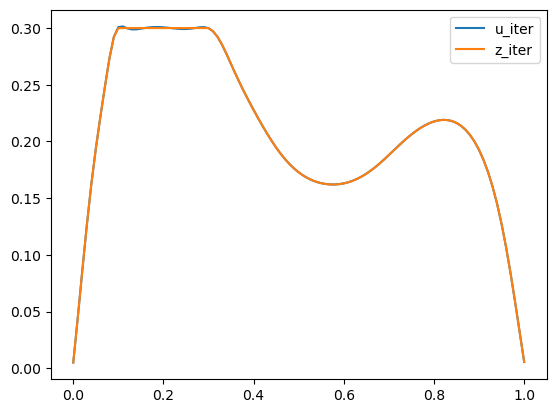

In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Sat Jul 23 17:56:52 2022

@author: yhr
"""

import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn

"geom"
class Space1d():
    def __init__(self,a,b):
        self.a=a
        self.b=b

    # def on_boundary(self,xt):
    #     return np.any(np.isclose(xt[:, :-1], [self.a, self.b]), axis=-1)
    # def on_initial(self,xt):
    #     return np.isclose(xt[:, -1:],self.t0).flatten()
    def uniform_points(self,n,boundary=True):
        if boundary:
            x=np.linspace(self.a, self.b, num=n)[:, None]
        else:
            x=np.linspace(self.a, self.b, num=n+1,endpoint=False)[1:, None]
        return x
    def random_points(self,nx):
        xr=np.random.rand(nx)[:, None]
        x=(self.b-self.a)*xr+self.a
        return x
    def uniform_boundary_points(self):
        return np.vstack((self.a, self.b))
N = 100
h = 1/N
domain=Space1d(0,1)
N=100
n=N+1
x=domain.uniform_points(n)
x_torch=torch.from_numpy(x).to(torch.float32).clone()
    
"model"
zd=0.3
nu=1/12
alpha=0.1
b=0.3
def yd_torch(x_torch):
    return 0*x_torch+zd
def BC_torch(x_torch):
    return 0*x_torch
"Network"
device = "cpu"
print(f"Using {device} device")
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        # self.flatten = nn.Flatten()
        self.yy = nn.Sequential(
            nn.Linear(1, 50),
            nn.Tanh(),
            nn.Linear(50, 50),
            nn.Tanh(),
            nn.Linear(50, 50),
            nn.Tanh(),
            nn.Linear(50, 50),
            nn.Tanh(),
            nn.Linear(50, 50),
            nn.Tanh(),
            nn.Linear(50, 1)
        )
        self.linear_Tanh_stack_u = nn.Sequential(
            nn.Linear(1, 50),
            nn.Tanh(),
            nn.Linear(50, 50),
            nn.Tanh(),
            nn.Linear(50, 50),
            nn.Tanh(),
            nn.Linear(50, 50),
            nn.Tanh(),
            nn.Linear(50, 50),
            nn.Tanh(),
            nn.Linear(50, 1)
        )

    def forward(self, x):
        # x = self.flatten(x)
        logits = self.yy(x)*x*(1-x),self.linear_Tanh_stack_u(x)
        # logits = self.linear_Tanh_stack_q(x),self.uu(x),self.vv(x)
        return logits
model = NeuralNetwork().to(device)
loss_fn = nn.MSELoss()
"trainning function"
Quiet=True
def train(model, loss_fn, optimizer):
    optimizer.zero_grad()
    loss = data.losses(model, loss_fn)
    loss.backward()
    optimizer.step()
    # loss= loss.item()
    if not Quiet:
        print(f"loss: {loss:>7f} ") 
def train_BFGS( model, loss_fn, optimizer):
    def closure():
        optimizer.zero_grad()
        loss = data.losses(model, loss_fn)
        loss.backward()
        return loss
    optimizer.step(closure)
    loss= closure().item()
    if not Quiet:
        print(f"loss: {loss:>7f} ") 
        
u_iter=0*x
    

def pde(x_torch,y_torch,u_torch,u_prox):
    "primal"
    x_np=x_torch.cpu().detach().numpy()
    x_np=np.round(x*(n-1))
    i_a=np.int32(x_np)
    u_prox_p=u_prox[i_a,0]
    u_prox_torch=torch.from_numpy(u_prox_p).to(torch.float32).clone()
    
    dy=torch.autograd.grad(y_torch, x_torch, grad_outputs=torch.ones_like(y_torch), create_graph=True)[0]
    ddy=torch.autograd.grad(dy, x_torch, grad_outputs=torch.ones_like(dy), create_graph=True)[0]
    error_pde=-nu*ddy+dy*y_torch-u_torch
    error_u=np.sqrt(beta+alpha)*(u_torch-(beta/(alpha+beta))*u_prox_torch)
    error_yd=(y_torch-yd_torch(x_torch))
#     error_u=0.98*np.sqrt(beta+alpha)*(u_torch-(beta/(alpha+beta))*u_prox_torch)
#     error_yd=1.15*(y_torch-yd_torch(x_torch))
    return torch.vstack((error_pde,error_yd,error_u))
class Burgers():
    def __init__(
        self,
        geometry,
        pde,
        bcs,
        u_prox,
        num_domain,
        para_bd,
    ):
        self.geom = geometry
        self.pde = pde
        self.para_bd=para_bd
        self.BC_torch = bcs
        self.u_prox=u_prox
        self.num_domain=num_domain
        
    def losses(self, model, loss_fn,random=False):
        if random:
            data_point=torch.from_numpy(self.geom.random_points(self.num_domain))
        else:
            data_point=torch.from_numpy(self.geom.uniform_points(self.num_domain))    
        x=data_point.to(torch.float32).clone().detach().requires_grad_(True)
        y= model(x)[0]
        u= model(x)[1]
        error_domain=self.pde(x,y,u,self.u_prox)
#         x_DBC=torch.from_numpy(self.geom.uniform_boundary_points()).to(torch.float32).clone()
#         error_DBC=model(x_DBC)[0]-self.BC_torch(x_DBC)
#         pred=torch.vstack((error_domain,self.para_bd*error_DBC))
        pred=error_domain
        loss = loss_fn(pred, torch.zeros_like(pred))
        return loss
beta=0.1
z_iter=u_iter
dual_iter=0*x
for i_outer in range(20):
    "k subproblem"
    u_prox=z_iter+dual_iter/beta
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    data = Burgers(domain,pde,BC_torch,u_prox,num_domain=n,para_bd=1)
    epochs =5000
    for t in range(epochs):
#         print(f"Epoch {t+1}\n-------------------------------")
        train(model, loss_fn, optimizer)
    print(f"Done!{i_outer}")    
    optimizer = torch.optim.LBFGS(model.parameters(), lr=1, max_iter=1000, max_eval=None, tolerance_grad=1e-09, tolerance_change=1e-09, history_size=100, line_search_fn= 'strong_wolfe')
    epochs =1
    for t in range(epochs):
#         print(f"Epoch {t+1}\n-------------------------------")
        train_BFGS(model, loss_fn, optimizer)
#     print("Done!")
    "z subproblem"
    y=model(x_torch)[0]
    y_iter=y.cpu().detach().numpy()
    u=model(x_torch)[1]
    u_iter=u.cpu().detach().numpy()

    u_temp=u_iter-dual_iter/beta
   
    z_iter=np.where(u_temp<=b,u_temp,b)
    plt.figure()
    plt.plot(x, u_iter, "-", label="u_iter")
    plt.plot(x, z_iter, "-", label="z_iter")
    plt.legend()
    plt.show()
    "dual update"
    dual_iter=dual_iter-beta*(u_iter-z_iter)

y=model(x_torch)[0]
u=model(x_torch)[1]
y_iter=y.cpu().detach().numpy()
u_iter=u.cpu().detach().numpy()


# plt.figure()
# plt.plot(x, u_iter, "-", label="u")
# plt.legend()
# plt.show()

# plt.figure()
# plt.plot(x, y_iter, "--", label="y")
# plt.legend()
# plt.show()


In [3]:
x.tofile("x_plot_PINN_direct.bin")
u_iter.tofile("u_PINN_direct.bin")
y_iter.tofile("y_PINN_direct.bin")